# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109B Data Science 2: Advanced Topics in Data Science 

## Lab 4 - Bayesian Analysis - EXTENDED

**Harvard University**<br>
**Spring 2020**<br>
**Instructors:** Mark Glickman, Pavlos Protopapas, and Chris Tanner<br>
**Lab Instructors:** Chris Tanner and Eleni Angelaki Kaxiras<br>
**Content:** Eleni Angelaki Kaxiras

---

<a id=top></a>

## Additions in this EXTENDED version

- Cleaner code in [Bayesian Linear Regression](#blr). <---- Edited material
- Cleaner code in [defining the Model](#model) <--- Edited Material
- [Hierarchical Models](#no4). <----- New material
- Some info on Bayesian [Logistic Regression with PyMC3](#LR) <-- New material

In [1]:
## RUN THIS CELL TO PROPERLY HIGHLIGHT THE EXERCISES
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2019-CS109B/master/content/styles/cs109.css").text
HTML(styles)

In [2]:
import pymc3 as pm
from pymc3 import summary
#import arviz as az
from matplotlib import gridspec

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import pandas as pd
import seaborn as sns
%matplotlib inline 

import warnings
warnings.filterwarnings('ignore')

In [4]:
print('Running on PyMC3 v{}'.format(pm.__version__))

Running on PyMC3 v3.8


In [5]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 20000;

<IPython.core.display.Javascript object>

In [6]:
#pandas trick
pd.options.display.max_columns = 50  # None -> No Restrictions
pd.options.display.max_rows = 200    # None -> Be careful with this 
pd.options.display.max_colwidth = 100
pd.options.display.precision = 3

## Learning Objectives

By the end of this lab, you should be able to:
* Apply Bayes Rule in calculating probabilities.
* Practice how to apply Bayesian analysis using PyMC3
* Avoid getting fired when talking to your Bayesian employer.

**This lab corresponds to Lectures 6, 7, and 8, and maps to Homework 3.**

## Table of Contents
1. The Bayesian Way of Thinking or Is this a Fair Coin?
2. [Intro to `pyMC3`](#pymc3). 
3. [Bayesian Linear Regression](#blr).

## 1. The Bayesian way of Thinking

```
Here is my state of knowledge about the situation. Here is some data, I am now going to revise my state of knowledge.
```

<div class="exercise"  style="background-color:#b3e6ff"><b>Table Exercise</b>: Discuss the statement above with your table mates and make sure everyone understands what it means and what constitutes Bayesian way of thinking. Finally, count the Bayesians among you. </div>

### A. Bayes Rule

\begin{equation}
\label{eq:bayes} 
P(A|\textbf{B}) = \frac{P(\textbf{B} |A) P(A) }{P(\textbf{B})} 
\end{equation}

$P(A|\textbf{B})$ is the **posterior** distribution, prob(hypothesis | data) 

$P(\textbf{B} |A)$ is the **likelihood** function, how probable is my data **B** for different values of the parameters

$P(A)$ is the marginal probability to observe the data, called the **prior**, this captures our belief about the data before observing it.

$P(\textbf{B})$ is the marginal distribution (sometimes called marginal likelihood)

<BR>
<div class="exercise"  style="background-color:#b3e6ff"><b>Table Exercise</b>: Solve the Monty Hall Paradox using Bayes Rule.</div> 
    
The problem we are about to solve gained fame as part of a game show "Let's Make A Deal" hosted by Monty Hall, hence its name. It was first raised by Steve Selvin in American Statistician in 1975.
    
The game is as follows: there are 3 doors behind **one** of which are the keys to a new car. There is a goat behind each of the other two doors. Let's assume your goal is to get the car and not a goat.

You are asked to pick one door, and let's say you pick **Door1**. The host knows where the keys are. Of the two remaining closed doors, he will always open the door that has a goat behind it. He'll say "I will do you a favor and open **Door2**". So he opens Door2 inside which there is, of course, a goat. He now asks you, do you want to open the initial Door you chose or change to **Door3**? Generally, in this game, when you are presented with this choice should you swap the doors?
**Initial Steps:**
- Start by defining the `events` of this probabilities game. One definition is:
    
    - $A_i$: car is behind door $i$    
        
    - $B_i$ host opens door $i$
    
$i\in[1,2,3]$
      
- In more math terms, the question is: is the probability of **the price is behind Door 1** higher than the probability of **the price is behind Door2**, given that an event **has occured**?

### B. Bayes Rule Revisited

We have data that we believe come from an underlying distribution of unknown parameters. If we find those parameters, we know everything about the process that generated this data and we can make inferences (create new data).

\begin{equation}
\label{eq:bayes} 
P(\theta|\textbf{D}) = \frac{P(\textbf{D} |\theta) P(\theta) }{P(\textbf{D})} 
\end{equation}

#### But what is $\theta \;$?

$\theta$ is an unknown yet fixed set of parameters. In Bayesian inference we express our belief about what $\theta$ might be and instead of trying to guess $\theta$ exactly, we look for its **probability distribution**. What that means is that we are looking for the **parameters** of that distribution. For example, for a Poisson distribution our $\theta$ is only $\lambda$. In a normal distribution, our $\theta$ is often just $\mu$ and $\sigma$.

### C. A review of Common Probability Distributions

#### Discrete Distributions

The random variable has a **probability mass function (pmf)** which measures the probability that our random variable will take a specific value $y$, denoted $P(Y=y)$.

- **Bernoulli** (binary outcome, success has probability $\theta$, $one$ trial):
$
P(Y=k) =  \theta^k(1-\theta)^{1-k}
$
<HR>
- **Binomial** (binary outcome, success has probability $\theta$, $k$ sucesses, $n$ trials):
\begin{equation}
P(Y=k) =  {{n}\choose{k}} \cdot \theta^k(1-\theta)^{n-k}
\end{equation}

*Note*: Binomial(1,$p$) = Bernouli($p$)
<HR>
- **Negative Binomial**
<HR>
- **Poisson** (counts independent events occurring at a rate $\lambda$)
\begin{equation}
P\left( Y=y|\lambda \right) = \frac{{e^{ - \lambda } \lambda ^y }}{{y!}}
\end{equation}
y = 0,1,2,...
<HR>
- **Discrete Uniform** 
<HR>
- **Categorical, or Multinulli** (random variables can take any of K possible categories, each having its own probability; this is a generalization of the Bernoulli distribution for a discrete variable with more than two possible outcomes, such as the roll of a die)
<HR>
- **Dirichlet-multinomial** (a generalization of the beta distribution for many variables)

#### Continuous Distributions

The random variable has a **probability density function (pdf)**.
- **Uniform** (variable equally likely to be near each value in interval $(a,b)$)
\begin{equation}
P(X = x) = \frac{1}{b - a}
\end{equation}
anywhere within the interval $(a, b)$, and zero elsewhere.
<HR>
- **Normal** (a.k.a. Gaussian)
\begin{equation}
X \sim  \mathcal{N}(\mu,\,\sigma^{2})
\end{equation} 

    A Normal distribution can be parameterized either in terms of precision $\tau$ or variance $\sigma^{2}$. The link between the two is given by
\begin{equation}
\tau = \frac{1}{\sigma^{2}}
\end{equation}
 - Expected mean $\mu$
 - Variance $\frac{1}{\tau}$ or $\sigma^{2}$
 - Parameters: `mu: float`, `sigma: float` or `tau: float`
<HR>
- **Beta** (where the variable ($\theta$) takes on values in the interval $[0,1]$, and is parametrized by two positive parameters, $\alpha$ and $\beta$ that control the shape of the distribution. Note that Beta is a good distribution to use for priors (beliefs) because its range is $[0,1]$ which is the natural range for a probability and because we can model a wide range of functions by changing the $\alpha$ and $\beta$ parameters.

\begin{equation}
\label{eq:beta} 
P(\theta|a,b) = \frac{1}{B(\alpha, \beta)} {\theta}^{\alpha - 1} (1 - \theta)^{\beta - 1} \propto {\theta}^{\alpha - 1} (1 - \theta)^{\beta - 1}
\end{equation}

where the normalisation constant, $B$, is a beta function of $\alpha$ and $\beta$,


\begin{equation}
B(\alpha, \beta) = \int_{t=0}^1 t^{\alpha - 1} (1 - t)^{\beta - 1} dt.
\end{equation}
<HR>
- **Exponential**
<HR>
- **Gamma**



 #### Code Resources:
 - Statistical Distributions in numpy/scipy: [scipy.stats](https://docs.scipy.org/doc/scipy/reference/stats.html)
 - Statistical Distributions in pyMC3: [distributions in PyMC3](https://docs.pymc.io/api/distributions.html) (we will see those below).

<div class="discussion"><b>Exercise: Discrete Probability Distributions Plots</b></div>

#### Poisson
Change the value of $\lambda$ in the Poisson PMF and see how the plot changes. Remember that the y-axis in a discrete probability distribution shows the probability of the random variable having a specific value in the x-axis.

\begin{equation}
P\left( X=y \right|\lambda) = \frac{{e^{ - \lambda } \lambda ^y }}{{y!}}
\end{equation}

for $y \ge0$.

Routine is `stats.poisson.pmf(x, lambda)`. $\lambda$ is our $\theta$ in this case. $\lambda$ is also the mean in this distribution.

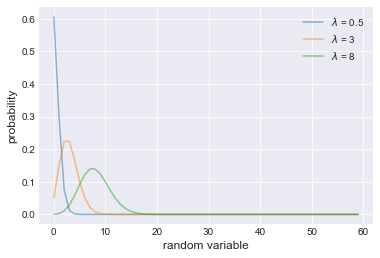

In [7]:
plt.style.use('seaborn-darkgrid')
x = np.arange(0, 60)
for lam in [0.5, 3, 8]:
    pmf = stats.poisson.pmf(x, lam)
    plt.plot(x, pmf, alpha=0.5, label='$\lambda$ = {}'.format(lam))
plt.xlabel('random variable', fontsize=12)
plt.ylabel('probability', fontsize=12)
plt.legend(loc=1)
plt.ylim=(-0.1)
plt.show()

#### Binomial

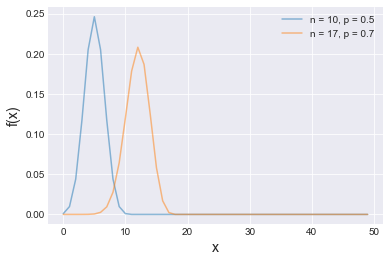

In [8]:
plt.style.use('seaborn-darkgrid')
x = np.arange(0, 50)
ns = [10, 17]
ps = [0.5, 0.7]
for n, p in zip(ns, ps):
    pmf = stats.binom.pmf(x, n, p)
    plt.plot(x, pmf, alpha=0.5, label='n = {}, p = {}'.format(n, p))
plt.xlabel('x', fontsize=14)
plt.ylabel('f(x)', fontsize=14)
plt.legend(loc=1)
plt.show()

<div class="discussion"><b>Exercise: Continuous Distributions Plot<br></div>

#### Uniform
    
Change the value of $\mu$ in the Uniform PDF and see how the plot changes.
    
Remember that the y-axis in a continuous probability distribution does not shows the actual probability of the random variable having a specific value in the x-axis because that probability is zero!. Instead, to see the probability that the variable is within a small margin we look at the integral below the curve of the PDF.

The uniform is often used as a noninformative prior.

```
Uniform - numpy.random.uniform(a=0.0, b=1.0, size)
```

$\alpha$ and $\beta$ are our parameters. `size` is how many tries to perform.
Our $\theta$ is basically the combination of the parameters a,b. We can also call it 
\begin{equation}
\mu = (a+b)/2
\end{equation}

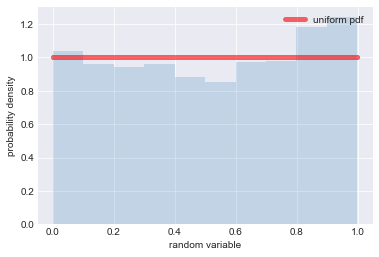

In [9]:
from scipy.stats import uniform

r = uniform.rvs(size=1000)
plt.plot(r, uniform.pdf(r),'r-', lw=5, alpha=0.6, label='uniform pdf')
plt.hist(r, density=True, histtype='stepfilled', alpha=0.2)
plt.ylabel(r'probability density')
plt.xlabel(f'random variable')
plt.legend(loc='best', frameon=False)
plt.show()

#### Beta

If we apply the formula we can see why we get these plots for the various values of $a$ and $b$. <BR>
Notice that for $a=b=1.$ we get a constant. From then on, as the values increase, we get a curve that looks more and more like a Gaussian.

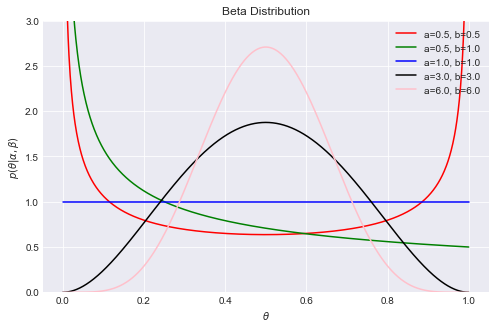

In [10]:
from scipy.stats import beta

alphas = [0.5, 0.5, 1., 3., 6.]
betas = [0.5, 1., 1., 3., 6.]
x = np.linspace(0, 1, 1000) 
colors = ['red', 'green', 'blue', 'black', 'pink']

fig, ax = plt.subplots(figsize=(8, 5))

for a, b, colors in zip(alphas, betas, colors):
    dist = beta(a, b)
    plt.plot(x, dist.pdf(x), c=colors,
             label=f'a={a}, b={b}')

ax.set_ylim(0, 3)

ax.set_xlabel(r'$\theta$')
ax.set_ylabel(r'$p(\theta|\alpha,\beta)$')
ax.set_title('Beta Distribution')

ax.legend(loc='best')
fig.show();

#### Gaussian

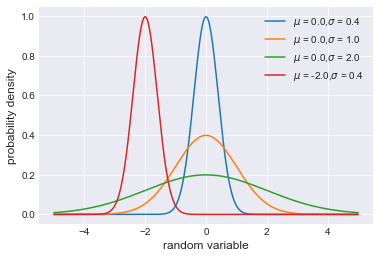

In [11]:
plt.style.use('seaborn-darkgrid')
x = np.linspace(-5, 5, 1000)
mus = [0., 0., 0., -2.]
sigmas = [0.4, 1., 2., 0.4]
for mu, sigma in zip(mus, sigmas):
    pdf = stats.norm.pdf(x, mu, sigma)
    plt.plot(x, pdf, label=r'$\mu$ = '+ f'{mu},' + r'$\sigma$ = ' + f'{sigma}') 
plt.xlabel('random variable', fontsize=12)
plt.ylabel('probability density', fontsize=12)
plt.legend(loc=1)
plt.show()

### D. Is this a Fair Coin?

Let's say you visit the casino in **Monte Carlo**. You want to test your theory that casinos are dubious places where coins have been manipulated to have a larger probability for tails. So you will try to estimate how fair a coin is based on a certain amount of  flips. <BR>
You have no prior opinion on the coin's fairness (i.e. what $p$ might be), and begin flipping the coin. You get either Heads ($H$) or Tails ($T$) as our observed data and want to see if your posterior probabilities change as you obtain more data, that is, more coin flips. A nice way to visualize this is to plot the posterior probabilities as we observe more flips (data). 

We will be using Bayes rule. $\textbf{D}$ is our data.

\begin{equation}
\label{eq:bayes} 
P(\theta|\textbf{D}) = \frac{P(\textbf{D} |\theta) P(\theta) }{P(\textbf{D})} 
\end{equation}

In the case of a coin toss when we observe $k$ heads in $n$ tosses:

\begin{equation}
\label{eq:bayes} 
P(\theta|\textbf{k}) = Beta(\alpha + \textbf{k}, \beta + n - \textbf{k}) 
\end{equation}

we can say that $\alpha$ and $\beta$ play the roles of a "prior number of heads" and "prior number of tails".

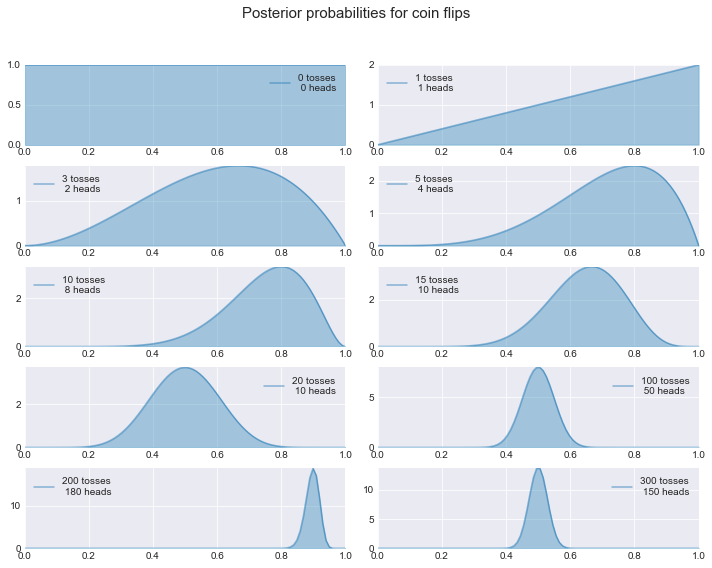

In [12]:
# play with the priors - here we manually set them but we could be sampling from a separate Beta
trials = np.array([0, 1, 3, 5, 10, 15, 20, 100, 200, 300])
heads = np.array([0, 1, 2, 4, 8, 10, 10, 50, 180, 150])
x = np.linspace(0, 1, 100)

# for simplicity we set a,b=1

plt.figure(figsize=(10,8))
for k, N in enumerate(trials):
    sx = plt.subplot(len(trials)/2, 2, k+1)
    posterior = stats.beta.pdf(x, 1 + heads[k], 1 + trials[k] - heads[k]) 
    plt.plot(x, posterior, alpha = 0.5, label=f'{trials[k]} tosses\n {heads[k]} heads');
    plt.fill_between(x, 0, posterior, color="#348ABD", alpha=0.4) 
    plt.legend(loc='upper left', fontsize=10)
    plt.legend()
    plt.autoscale(tight=True)
    
plt.suptitle("Posterior probabilities for coin flips", fontsize=15);
plt.tight_layout()
plt.subplots_adjust(top=0.88)

<a id=pymc3></a> [Top](#top)

## 2. Introduction to `pyMC3`
 
PyMC3 is a Python library for programming Bayesian analysis, and more specifically, data creation, model definition, model fitting, and posterior analysis. It uses the concept of a `model` which contains assigned parametric statistical distributions to unknown quantities in the model. Within models we define random variables and their distributions. A distribution requires at least a `name` argument, and other `parameters` that define it. You may also use the `logp()` method in the model to build the model log-likelihood function. We define and fit the model.

PyMC3 includes a comprehensive set of pre-defined statistical distributions that can be used as model building blocks. Although they are not meant to be used outside of a `model`, you can invoke them by using the prefix `pm`, as in `pm.Normal`. 

#### Markov Chain Monte Carlo (MCMC) Simulations

PyMC3 uses the **No-U-Turn Sampler (NUTS)** and the **Random Walk Metropolis**, two Markov chain Monte Carlo (MCMC) algorithms for sampling in posterior space. Monte Carlo gets into the name because when we sample in posterior space, we choose our next move via a pseudo-random process. NUTS is a sophisticated algorithm that can handle a large number of unknown (albeit continuous) variables.

In [13]:
help(pm.Poisson)

Help on class Poisson in module pymc3.distributions.discrete:

class Poisson(pymc3.distributions.distribution.Discrete)
 |  Poisson(name, *args, **kwargs)
 |  
 |  Poisson log-likelihood.
 |  
 |  Often used to model the number of events occurring in a fixed period
 |  of time when the times at which events occur are independent.
 |  The pmf of this distribution is
 |  
 |  .. math:: f(x \mid \mu) = \frac{e^{-\mu}\mu^x}{x!}
 |  
 |  .. plot::
 |  
 |      import matplotlib.pyplot as plt
 |      import numpy as np
 |      import scipy.stats as st
 |      plt.style.use('seaborn-darkgrid')
 |      x = np.arange(0, 15)
 |      for m in [0.5, 3, 8]:
 |          pmf = st.poisson.pmf(x, m)
 |          plt.plot(x, pmf, '-o', label='$\mu$ = {}'.format(m))
 |      plt.xlabel('x', fontsize=12)
 |      plt.ylabel('f(x)', fontsize=12)
 |      plt.ylim(0)
 |      plt.legend(loc=1)
 |      plt.show()
 |  
 |  ========  ==========================
 |  Support   :math:`x \in \mathbb{N}_0`
 |  Mean      

<a id=blr></a> [Top](#top)

## 3. Bayesian Linear Regression

#### Defining the Problem

Our problem is the following: we want to perform multiple linear regression to predict an outcome variable $Y$ which depends on variables $\bf{x}_1$ and $\bf{x}_2$.

We will model $Y$ as normally distributed observations with an expected value $mu$ that is a linear function of the two predictor variables, $\bf{x}_1$ and $\bf{x}_2$.

\begin{equation}
Y \sim  \mathcal{N}(\mu,\,\sigma^{2})
\end{equation} 

\begin{equation}
\mu = \beta_0 + \beta_1 \bf{x}_1 + \beta_2 x_2 
\end{equation}

where $\sigma^2$ represents the measurement error (in this example, we will use $\sigma^2 = 10$)

We also choose the parameters to have normal distributions with those parameters set by us.

\begin{eqnarray}
\beta_i \sim  \mathcal{N}(0,\,10) \\
\sigma^2 \sim  |\mathcal{N}(0,\,10)|
\end{eqnarray}   
We will artificially create the data to predict on. We will then see if our model predicts them correctly.

#### Artificially creating some data to test our model.

In [14]:
np.random.seed(123)

# True parameter values < --- our model does not see these
sigma = 1
beta0 = 1
beta = [1, 2.5]   

# Size of dataset
size = 100

# Predictor variable
x1 = np.linspace(0, 1., size)
x2 = np.linspace(0,2., size)

# Simulate outcome variable
Y = beta0 + beta[0]*x1 + beta[1]*x2 + np.random.randn(size)*sigma

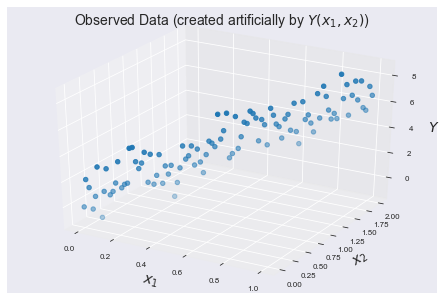

In [15]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
fontsize=14
labelsize=8
title='Observed Data (created artificially by ' + r'$Y(x_1,x_2)$)'
ax = fig.add_subplot(111, projection='3d')

ax.scatter(x1, x2, Y)
ax.set_xlabel(r'$x_1$', fontsize=fontsize)
ax.set_ylabel(r'$x_2$', fontsize=fontsize)
ax.set_zlabel(r'$Y$', fontsize=fontsize)

ax.tick_params(labelsize=labelsize)

fig.suptitle(title, fontsize=fontsize)        
fig.tight_layout(pad=.1, w_pad=10.1, h_pad=2.)
#fig.subplots_adjust(); #top=0.5
plt.tight_layout
plt.show()

Now let's see if our model will correctly predict the values for our unknown parameters, namely $b_0$, $b_1$, $b_2$ and $\sigma$.

<a id=model></a>


#### Defining a Model in PyMC3

In [16]:
from pymc3 import Model, Normal, HalfNormal, model_to_graphviz
from pymc3 import NUTS, sample, find_MAP
from scipy import optimize

#### Building the model

**Step1:** We choose the probability model for our experiment. 

```
Y_obs = Normal('Y_obs', mu=mu, sd=sigma, observed=Y)
```

**Step2:** Choose a prior distributions of the two rates, what we believe the rates were before we observed the data, and the switchpoint. 
```
 beta0 = Normal('beta0', mu=0, sd=10)
 # Note: betas is a vector of two variables, b1 and b2, (denoted by shape=2)
 # so, in array notation, our beta1 = betas[0], and beta2=betas[1]
 betas = Normal('betas', mu=0, sd=10, shape=2) 
 sigma = HalfNormal('sigma', sd=1)
```

**Note:** Watch for missing values. Missing values are handled transparently by passing a MaskedArray or a pandas.DataFrame. Behind the scenes, another random variable, disasters.missing_values is created to model the missing values. If you pass a np.array with missing values you will get an error.

In [17]:
with Model() as my_linear_model:

    # Priors for unknown model parameters, specifically created stochastic random variables 
    # with Normal prior distributions for the regression coefficients,
    # and a half-normal distribution for the standard deviation of the observations.
    # These are our parameters.
    
    beta0 = Normal('beta0', mu=0, sd=10)
    # Note: betas is a vector of two variables, b1 and b2, (denoted by shape=2)
    # so, in array notation, our beta1 = betas[0], and beta2=betas[1]
    betas = Normal('betas', mu=0, sd=10, shape=2) 
    sigma = HalfNormal('sigma', sd=1)
    
    # mu is what is called a deterministic random variable, which implies that its value is completely
    # determined by its parents’ values (betas and sigma in our case). 
    # There is no uncertainty in the variable beyond that which is inherent in the parents’ values
    
    mu = beta0 + betas[0]*x1 + betas[1]*x2
    
    # Likelihood function = how probable is my observed data?
    # This is a special case of a stochastic variable that we call an observed stochastic.
    # It is identical to a standard stochastic, except that its observed argument, 
    # which passes the data to the variable, indicates that the values for this variable were observed, 
    # and should not be changed by any fitting algorithm applied to the model. 
    # The data can be passed in the form of either a numpy.ndarray or pandas.DataFrame object.
    
    Y_obs = Normal('Y_obs', mu=mu, sd=sigma, observed=Y)

Note: If our problem was a classification for which we would use Logistic regression see [below](#LR) 

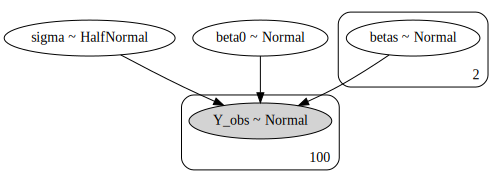

In [18]:
## do not worry about this, it's just a nice graph to have
model_to_graphviz(my_linear_model)

#### Fitting the Model with MAP (FYI, we will not directly use this method)

In Bayesian analysis we have our **prior(s)**, we define our **likelihood**, and, having specified our **model**, we try to calculate posterior estimates for the unknown variables in the model. We could try to calculate the posterior estimates analytically, but for most the models, this is not feasible. What we do then is compute summaries based on samples drawn from the posterior distribution using Markov Chain Monte Carlo (MCMC) sampling methods. 

\begin{equation}
\label{eq:beta} 
P(\theta|\textbf{D}) \rightarrow  \{\theta_1,....\theta_n\}
\end{equation}

Then we can find any estimate we want by using these samples, for example:

\begin{equation}
\mathbb{E}[f(\theta] = \int d\theta{p(\theta) f(\theta)} 
\end{equation}

So we calculate the maximum a posteriori **(MAP)** point using optimization methods.

\begin{equation}
f(\hat{\theta}), \hat{\theta} = argmax ({p(\theta))} 
\end{equation}

The maximum a posteriori **(MAP)** estimate for a model, is the mode of the posterior distribution and is generally found using numerical optimization methods. This is often fast and easy to do, but only gives a point estimate for the parameters and can be biased if the mode isn’t representative of the distribution. PyMC3 provides this functionality with the find_MAP function. 

**MAP estimate** is not always reasonable, especially if the mode is at an extreme or we have a multimodal distribution, or we have high dimensional posteriors. This will often occur in hierarchical models with the variance parameter for the random effect. If the individual group means are all the same, the posterior will have near infinite density if the variance parameter for the group means is almost zero. Most techniques for finding the MAP estimate only find a local optimium (which is often good enough), and can therefore fail badly for multimodal posteriors, as mentioned above.

To solve these issues we turn to sampling as our method for finding the posterior.

You do not have to worry about **MAP** in our problems. Our pyMC3 models use the MAP method to initialize the variables under the hood and we do not have to explicitly set this. 

#### Fitting the Model with Sampling - Doing Inference

See below for PyMC3's sampling method. As you can see it has quite a few parameters. Most of them are set to default values by the package. For some, it's useful to set your own values.
```
pymc3.sampling.sample(draws=500, step=None, init='auto', n_init=200000, start=None, trace=None, chain_idx=0, chains=None, cores=None, tune=500, progressbar=True, model=None, random_seed=None, discard_tuned_samples=True, compute_convergence_checks=True, **kwargs)
```

Parameters to set:

- **draws** (int): number of samples to draw, defaults to 500. 
- **tune** (int): number of iterations to tune, defaults to 500. 
- **target_accept** (float in $[0, 1]$). The step size is tuned such that we approximate this acceptance rate. Higher values like 0.9 or 0.95 often work better for problematic posteriors.
- (optional) **cores** (int) number of chains to run in parallel, defaults to the number of CPUs in the system, but at most 4.

`pm.sample` returns a `pymc3.backends.base.MultiTrace` object that contains the samples. We usually name it `trace`. All the information about the posterior is in `trace`, which also provides statistics about the sampler.

In [19]:
## uncomment this to see more about pm.sample
help(pm.sample)

Help on function sample in module pymc3.sampling:

sample(draws=500, step=None, init='auto', n_init=200000, start=None, trace=None, chain_idx=0, chains=None, cores=None, tune=500, progressbar=True, model=None, random_seed=None, discard_tuned_samples=True, compute_convergence_checks=True, **kwargs)
    Draw samples from the posterior using the given step methods.
    
    Multiple step methods are supported via compound step methods.
    
    Parameters
    ----------
    draws : int
        The number of samples to draw. Defaults to 500. The number of tuned samples are discarded
        by default. See ``discard_tuned_samples``.
    init : str
        Initialization method to use for auto-assigned NUTS samplers.
    
        * auto : Choose a default initialization method automatically.
          Currently, this is ``'jitter+adapt_diag'``, but this can change in the future.
          If you depend on the exact behaviour, choose an initialization method explicitly.
        * adapt_diag 

In [20]:
help(pm.backends.base.MultiTrace)

Help on class MultiTrace in module pymc3.backends.base:

class MultiTrace(builtins.object)
 |  MultiTrace(straces)
 |  
 |  Main interface for accessing values from MCMC results.
 |  
 |  The core method to select values is `get_values`. The method
 |  to select sampler statistics is `get_sampler_stats`. Both kinds of
 |  values can also be accessed by indexing the MultiTrace object.
 |  Indexing can behave in four ways:
 |  
 |  1. Indexing with a variable or variable name (str) returns all
 |     values for that variable, combining values for all chains.
 |  
 |     >>> trace[varname]
 |  
 |     Slicing after the variable name can be used to burn and thin
 |     the samples.
 |  
 |     >>> trace[varname, 1000:]
 |  
 |     For convenience during interactive use, values can also be
 |     accessed using the variable as an attribute.
 |  
 |     >>> trace.varname
 |  
 |  2. Indexing with an integer returns a dictionary with values for
 |     each variable at the given index (corresp

In [21]:
with my_linear_model:
 
    print(f'Starting MCMC process')
    # draw 2000 posterior samples and run the default number of chains = 4 
    trace = sample(2000, tune=1000, target_accept=0.9) 
    print(f'DONE')

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


Starting MCMC process


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, betas, beta0]
Sampling 4 chains, 0 divergences: 100%|██████████| 12000/12000 [01:01<00:00, 194.92draws/s]


DONE


#### Model Plotting

PyMC3 provides a variety of visualizations via plots: [https://docs.pymc.io/api/plots.html](https://docs.pymc.io/api/plots.html).

One of them is the `traceplot`, another is the `compareplot`. 

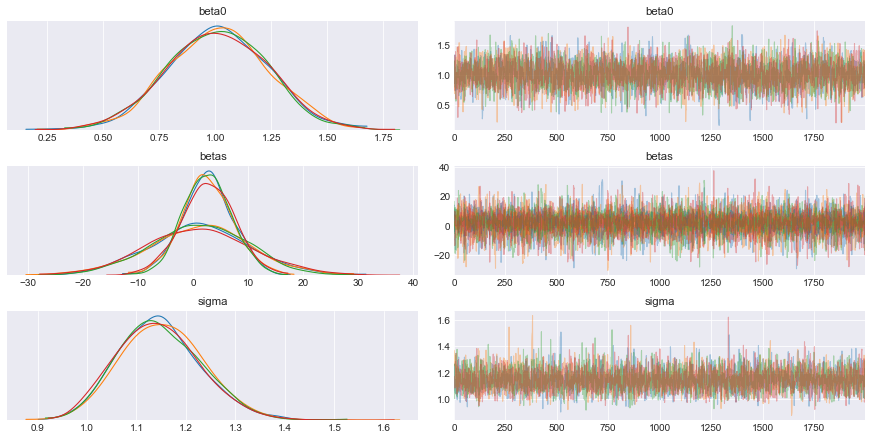

In [22]:
from pymc3 import traceplot, compareplot, plot_posterior, forestplot
traceplot(trace);

In [23]:
help(pm.Normal)

Help on class Normal in module pymc3.distributions.continuous:

class Normal(pymc3.distributions.distribution.Continuous)
 |  Normal(name, *args, **kwargs)
 |  
 |  Univariate normal log-likelihood.
 |  
 |  The pdf of this distribution is
 |  
 |  .. math::
 |  
 |     f(x \mid \mu, \tau) =
 |         \sqrt{\frac{\tau}{2\pi}}
 |         \exp\left\{ -\frac{\tau}{2} (x-\mu)^2 \right\}
 |  
 |  Normal distribution can be parameterized either in terms of precision
 |  or standard deviation. The link between the two parametrizations is
 |  given by
 |  
 |  .. math::
 |  
 |     \tau = \dfrac{1}{\sigma^2}
 |  
 |  .. plot::
 |  
 |      import matplotlib.pyplot as plt
 |      import numpy as np
 |      import scipy.stats as st
 |      plt.style.use('seaborn-darkgrid')
 |      x = np.linspace(-5, 5, 1000)
 |      mus = [0., 0., 0., -2.]
 |      sigmas = [0.4, 1., 2., 0.4]
 |      for mu, sigma in zip(mus, sigmas):
 |          pdf = st.norm.pdf(x, mu, sigma)
 |          plt.plot(x, pdf, labe

In [24]:
trace.varnames

['beta0', 'betas', 'sigma_log__', 'sigma']

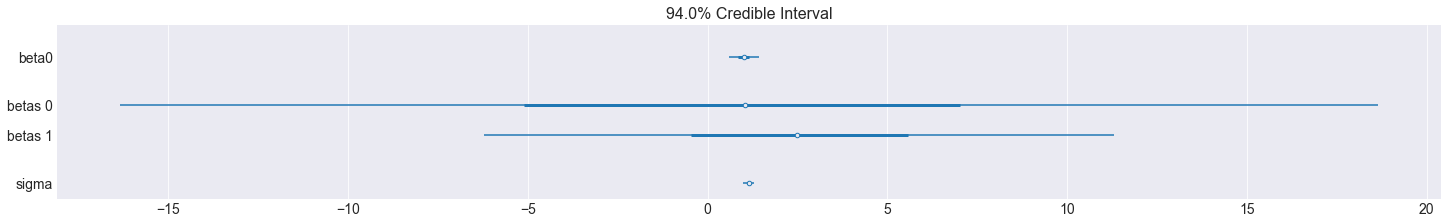

In [25]:
axes = pm.plot_forest(trace, kind='forestplot',
                       var_names=['beta0', 'betas', 'sigma'],
                       combined=True,
                       ridgeplot_overlap=3,
                       figsize=(20, 3))

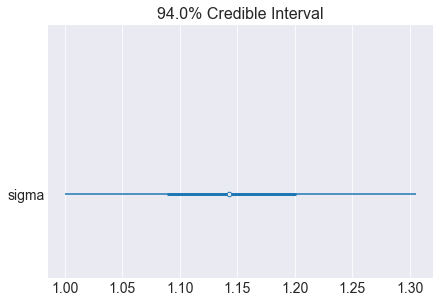

In [26]:
# plot individual parameters which maybe do not show 
# well in combined plot due to scaling
varname = ['sigma']
pm.plot_forest(trace, varnames=varname, combined=True);

$\hat{R}$ is a metric for comparing how well a chain has converged to the equilibrium distribution by comparing its behavior to other randomly initialized Markov chains. Multiple chains initialized from different initial conditions should give similar results.
If all chains converge to the same equilibrium, $\hat{R}$ will be 1. If the chains have not converged to a common distribution, $\hat{R}$ will be > 1.01. $\hat{R}$ is a necessary but not sufficient condition.

For details on the $\hat{R}$ see *Gelman and Rubin (1992)*. 

In [27]:
help(pm.backends.base.MultiTrace)

Help on class MultiTrace in module pymc3.backends.base:

class MultiTrace(builtins.object)
 |  MultiTrace(straces)
 |  
 |  Main interface for accessing values from MCMC results.
 |  
 |  The core method to select values is `get_values`. The method
 |  to select sampler statistics is `get_sampler_stats`. Both kinds of
 |  values can also be accessed by indexing the MultiTrace object.
 |  Indexing can behave in four ways:
 |  
 |  1. Indexing with a variable or variable name (str) returns all
 |     values for that variable, combining values for all chains.
 |  
 |     >>> trace[varname]
 |  
 |     Slicing after the variable name can be used to burn and thin
 |     the samples.
 |  
 |     >>> trace[varname, 1000:]
 |  
 |     For convenience during interactive use, values can also be
 |     accessed using the variable as an attribute.
 |  
 |     >>> trace.varname
 |  
 |  2. Indexing with an integer returns a dictionary with values for
 |     each variable at the given index (corresp

In [28]:
# Remember, the true (hidden) variables are: sigma, beta0, beta1, beta2 = 1,1,1,2.5 
# We want R_hat < 1.3
results = pm.summary(trace)  
results

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
beta0,1.008,0.225,0.589,1.427,0.003,0.002,4838.0,4817.0,4850.0,4290.0,1.0
betas[0],0.968,9.197,-16.351,18.652,0.171,0.131,2890.0,2476.0,2900.0,2882.0,1.0
betas[1],2.536,4.600,-6.216,11.296,0.085,0.067,2902.0,2349.0,2913.0,2897.0,1.0
sigma,1.147,0.084,1.000,1.305,0.001,0.001,4293.0,4254.0,4339.0,4027.0,1.0


This linear regression example is from the original paper on PyMC3: *Salvatier J, Wiecki TV, Fonnesbeck C. 2016. Probabilistic programming in Python using PyMC3. PeerJ Computer Science 2:e55 https://doi.org/10.7717/peerj-cs.55*

<a id=no4></a> [Top](#top)

## 4. Hierarchical Models


**Gelman et al.** famous radon dataset is a classic for hierarchical modeling. In this dataset the amount of the radioactive gas radon has been measured among different households in all county's of several states. Radon gas is known to be the highest cause of lung cancer in non-smokers. It is believed to be more strongly present in households containing a basement and to differ in amount present among types of soil. Here we'll investigate this differences and try to make predictions of radonlevels in different county's based on the county itself and the presence of a basement.

![aws-dog](../images/radon_house.jpg)

In [29]:
df = pd.read_csv('../data/radon.csv', index_col=[0])
df['log_radon'] = df['log_radon'].astype('float')
county_names = df.county.unique()
county_idx = df.county_code.values

n_counties = len(df.county.unique())
df.head()

,idnum,state,state2,stfips,zip,region,typebldg,floor,room,basement,windoor,rep,stratum,wave,starttm,stoptm,startdt,stopdt,activity,pcterr,adjwt,dupflag,zipflag,cntyfips,county,fips,Uppm,county_code,log_radon
0,5081,MN,MN,27,55735,5,1,1,3,N,,2,4,41,930,930,12088,12288,2.2,9.7,1146.499,1,0,1,AITKIN,27001,0.502,0,0.833
1,5082,MN,MN,27,55748,5,1,0,4,Y,,5,2,40,1615,1615,11888,12088,2.2,14.5,471.366,0,0,1,AITKIN,27001,0.502,0,0.833
2,5083,MN,MN,27,55748,5,1,0,4,Y,,3,2,42,1030,1515,20288,21188,2.9,9.6,433.317,0,0,1,AITKIN,27001,0.502,0,1.099
3,5084,MN,MN,27,56469,5,1,0,4,Y,,2,2,24,1410,1410,122987,123187,1.0,24.3,461.624,0,0,1,AITKIN,27001,0.502,0,0.095
4,5085,MN,MN,27,55011,3,1,0,4,Y,,3,2,40,600,600,12888,13088,3.1,13.8,433.317,0,0,3,ANOKA,27003,0.429,1,1.163


Each **row** in the dataframe represents the radon measurements for **one house** in a specific county including whether the house has a basement (floor = 0) or not (floor = 1). We are interested in whether having a basement increases the radon measured in the house.

To keep things simple let's keep only the following three variables: `county`, `log_radon`, and `floor`

In [30]:
# keep only these variables
data = df[['county', 'log_radon', 'floor']]
data.head()

,county,log_radon,floor
0,AITKIN,0.833,1
1,AITKIN,0.833,0
2,AITKIN,1.099,0
3,AITKIN,0.095,0
4,ANOKA,1.163,0


Let's check how many different counties we have. We also notice that they have a different number of houses. Some have a large number of houses measured, some only 1.

In [31]:
data['county'].value_counts().head(5)

ST LOUIS      116
HENNEPIN      105
DAKOTA         63
ANOKA          52
WASHINGTON     46
Name: county, dtype: int64

In [32]:
data['county'].value_counts()[-5:]

COOK               2
YELLOW MEDICINE    2
MURRAY             1
MAHNOMEN           1
WILKIN             1
Name: county, dtype: int64

In [33]:
# let's add a column that numbers the counties from 0 to n
raw_ids = np.unique(data['county'])
raw2newid = {x:np.where(raw_ids == x)[0][0] for x in raw_ids}

data['county_id'] = data['county'].map(raw2newid)
data

,county,log_radon,floor,county_id
0,AITKIN,0.833,1,0
1,AITKIN,0.833,0,0
2,AITKIN,1.099,0,0
3,AITKIN,0.095,0,0
4,ANOKA,1.163,0,1
...,...,...,...,...
914,WRIGHT,1.872,0,83
915,WRIGHT,1.526,0,83
916,WRIGHT,1.629,0,83
917,YELLOW MEDICINE,1.335,0,84


### Pooling: Same Linear Regression for all

We can just pool all the data and estimate one big regression to asses the influence of having a basement on radon levels across all counties. Our model would be:

\begin{equation}
y_{i} = \alpha + \beta*floor_{i} 
\end{equation}

Where $i$ represents the measurement (house), and floor contains a 0 or 1 if the house has a basement or not. By ignoring the county feature, we do not differenciate on counties.

In [34]:
with pm.Model() as pooled_model:
    # common priors for all
    a = pm.Normal('a', mu=0, sigma=100)   
    b = pm.Normal('b', mu=0, sigma=100)

    # radon estimate
    radon_est = a + b*data['floor'].values

    # likelihood after radon observations
    radon_obs = pm.Normal('radon_obs', mu=radon_est,  
                           observed=data['log_radon']) # note here we enter the whole dataset

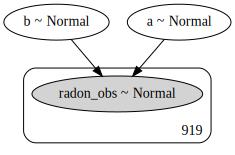

In [35]:
model_to_graphviz(pooled_model)

In [36]:
with pooled_model:
 
    pooled_trace = sample(2000, tune=1000, target_accept=0.9, chains=2) 
    print(f'DONE')

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [b, a]
Sampling 2 chains, 0 divergences: 100%|██████████| 6000/6000 [00:01<00:00, 3149.25draws/s]


DONE


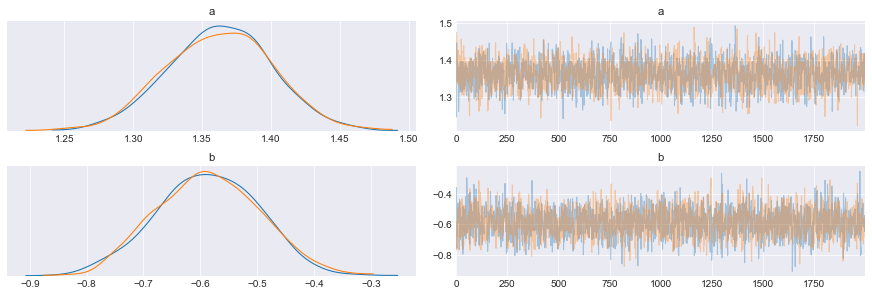

In [37]:
pm.traceplot(pooled_trace);

Remember, with the pooled model we have only one intercept, $\alpha$, and only one slope, $\beta$ for all the counties. Let's plot the regression lines.

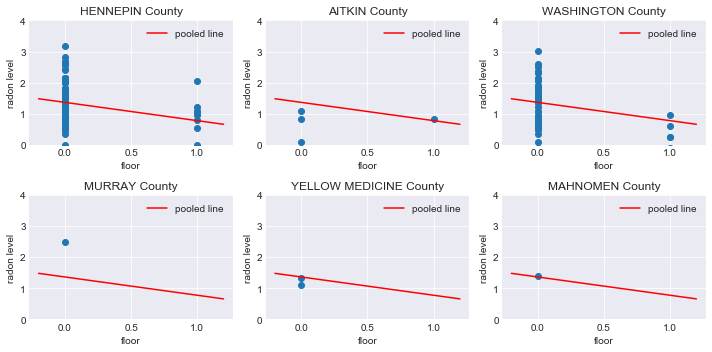

In [38]:
# plot just a subset of the countries
counties = ['HENNEPIN','AITKIN','WASHINGTON', 'MURRAY', 'YELLOW MEDICINE', 'MAHNOMEN']

plt.figure(figsize=(10,5))
rows = 2
gs = gridspec.GridSpec(rows, len(counties)//rows)
  
for i, county in enumerate(counties):
    county_data = data.loc[data['county']==county]
    x = np.linspace(-0.2, 1.2)    
    radon_est = pooled_trace['a'].mean() + pooled_trace['b'].mean()*x
    subplt = plt.subplot(gs[i])

    subplt.set_ylim(0.,4.)
    subplt.scatter(county_data['floor'], county_data['log_radon'])
    subplt.plot(x, radon_est, c='r', label='pooled line');
    subplt.set_xlabel('floor', fontsize=10)
    subplt.set_ylabel('radon level', fontsize=10)
    subplt.set_title(str(county) + ' County')
    subplt.legend()
    plt.tight_layout()

### Unpooling: Separate Linear Regression for each county 

We believe that different counties have different relationships of radon and basements. Our model would be:

\begin{equation}
radon_{i,c} = \alpha_c + \beta_c*floor_{i,c} 
\end{equation}

Where $i$ represents the measurement, $c$ the county, and floor contains a 0 or 1 if the house has a basement or not. 

Notice we have separate coefficients for each county in $a_c$ and $b_c$. They are totally different, they do not even come from the same distribution.

We will do this for only one county, as an example. We pick HENNEPIN county. 

In [39]:
# chose a county
county = 'MEEKER'
county_data = data.loc[data['county']==county]
county_data.head()

,county,log_radon,floor,county_id
479,MEEKER,0.875,0,45
480,MEEKER,1.386,0,45
481,MEEKER,1.988,0,45
482,MEEKER,0.788,0,45
483,MEEKER,1.194,0,45


In [40]:
help(pm.Normal)

Help on class Normal in module pymc3.distributions.continuous:

class Normal(pymc3.distributions.distribution.Continuous)
 |  Normal(name, *args, **kwargs)
 |  
 |  Univariate normal log-likelihood.
 |  
 |  The pdf of this distribution is
 |  
 |  .. math::
 |  
 |     f(x \mid \mu, \tau) =
 |         \sqrt{\frac{\tau}{2\pi}}
 |         \exp\left\{ -\frac{\tau}{2} (x-\mu)^2 \right\}
 |  
 |  Normal distribution can be parameterized either in terms of precision
 |  or standard deviation. The link between the two parametrizations is
 |  given by
 |  
 |  .. math::
 |  
 |     \tau = \dfrac{1}{\sigma^2}
 |  
 |  .. plot::
 |  
 |      import matplotlib.pyplot as plt
 |      import numpy as np
 |      import scipy.stats as st
 |      plt.style.use('seaborn-darkgrid')
 |      x = np.linspace(-5, 5, 1000)
 |      mus = [0., 0., 0., -2.]
 |      sigmas = [0.4, 1., 2., 0.4]
 |      for mu, sigma in zip(mus, sigmas):
 |          pdf = st.norm.pdf(x, mu, sigma)
 |          plt.plot(x, pdf, labe

In [41]:
with pm.Model() as unpooled_model:
    mu_a = pm.Normal('mu_a', mu=0., sigma=100)
    sigma_a = pm.HalfNormal('sigma_a', 5.)
    mu_b = pm.Normal('mu_b', mu=0., sigma=100)
    sigma_b = pm.HalfNormal('sigma_b', 5.)
    
    a = pm.Normal('a', mu=mu_a, sigma=sigma_a)   
    b = pm.Normal('b', mu=mu_b, sigma=sigma_b)

    radon_est = a + b*county_data['floor'].values

    radon_obs = pm.Normal('radon_like', mu=radon_est,  
                           observed=county_data['log_radon']) 

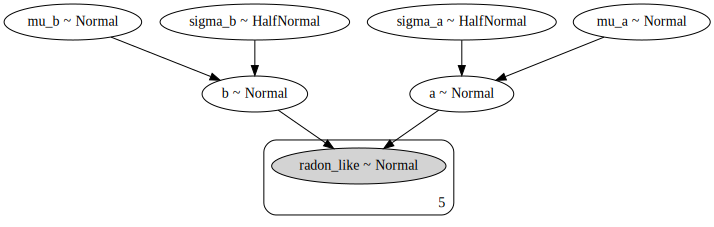

In [42]:
model_to_graphviz(unpooled_model)

In [43]:
with unpooled_model:
 
    unpooled_trace = sample(2000, tune=1000, target_accept=0.9, chains=2, cores=1) 
    print(f'DONE')

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [b, a, sigma_b, mu_b, sigma_a, mu_a]
Sampling chain 1, 235 divergences: 100%|██████████| 3000/3000 [00:32<00:00, 91.66it/s] 
There were 81 divergences after tuning. Increase `target_accept` or reparameterize.
There were 317 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7831194829719486, but should be close to 0.9. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


DONE


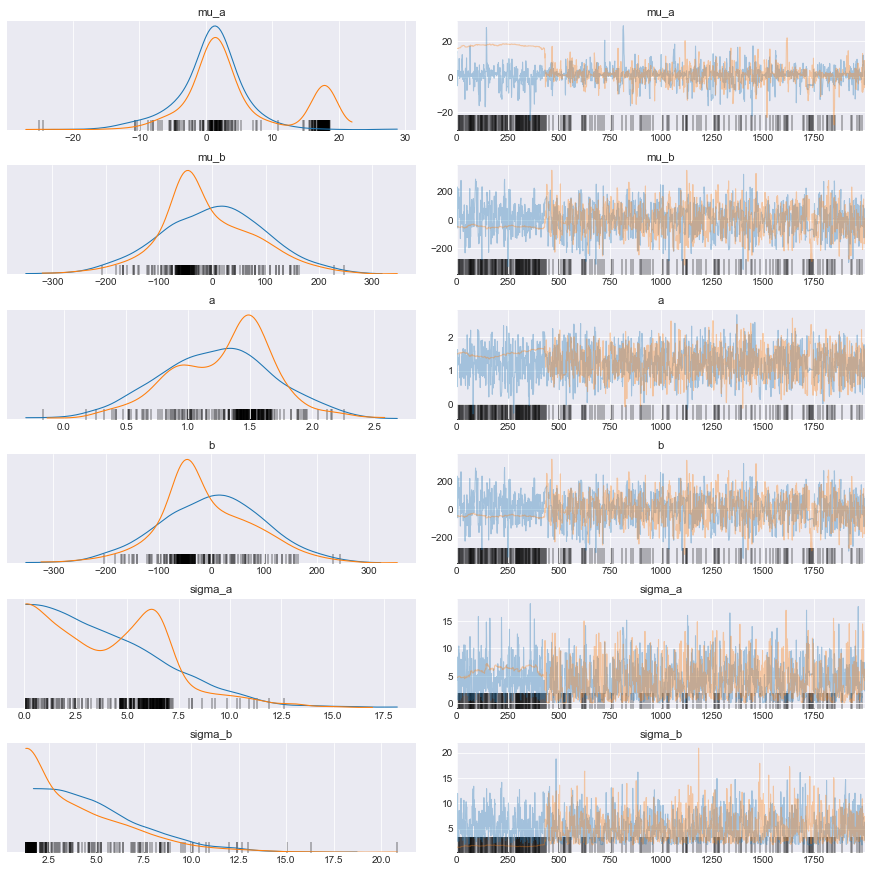

In [44]:
pm.traceplot(unpooled_trace);

Print the regression line for our chosen county alone.

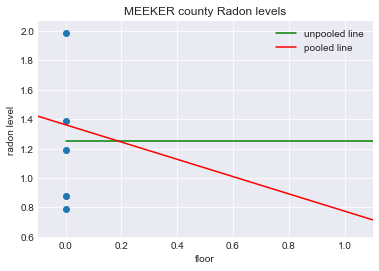

In [45]:
county = 'MEEKER'
county_data = data.loc[data['county']==county]

x = np.arange(len(county_data['floor'].values))
radon_est_unpooled = unpooled_trace['a'].mean() + unpooled_trace['b'].mean()*county_data['floor'].values

xx = np.linspace(-0.2, 1.2)    
radon_est_pooled = pooled_trace['a'].mean() + pooled_trace['b'].mean()*xx

plt.scatter(county_data['floor'], county_data['log_radon'])
plt.xlim(-0.1,1.1)
plt.xlabel('floor', fontsize=10)
plt.ylabel('radon level', fontsize=10)
plt.title(f'{str(county)} county Radon levels')
plt.plot(x, radon_est_unpooled, c='g', label='unpooled line');
plt.plot(xx, radon_est_pooled, c='r', label='pooled line');
plt.legend();

### Partial pooling: Hierarchical Regression (Varying-Coefficients Model)

Merely by the fact that all counties are counties, they share similarities, so there is a middle ground to both of these extremes. Specifically, we may assume that while $\alpha_c$ and $\beta_c$are different for each county as in the unpooled case, the coefficients are all drawn from the same distribution:

\begin{equation}
radon_{i,c} = \alpha_c + \beta_c*floor_{i,c} 
\end{equation}   

\begin{equation}
a_c \sim  \mathcal{N}(\mu_a,\,\sigma_a^{2})
\end{equation} 
\begin{equation}
b_c \sim  \mathcal{N}(\mu_b,\,\sigma_b^{2})
\end{equation}

where the common parameters are:
\begin{eqnarray}
\mu_a \sim  \mathcal{N}(0,\,10) \\
\sigma_a^2 \sim  |\mathcal{N}(0,\,10)| \\
\mu_b \sim  \mathcal{N}(0,\,10) \\
\sigma_b^2 \sim  |\mathcal{N}(0,\,10)|
\end{eqnarray}

Add math for mu and sigma


The different counties are effectively sharing information through the commin priors. We are thus observing what is known as shrinkage; modeling the groups not as independent from each other, neither as a single group but rather as related.

<div class="discussion"><b>Discussion:</b> how can we best handle this data? Does it make sense to make inferences without taking into account the county?</div>

### Defining the Model for the Hierarchical Model 

In [46]:
with pm.Model() as hierarchical_model:
    # Hyperpriors for group nodes
    mu_a = pm.Normal('mu_a', mu=0., sigma=100)
    sigma_a = pm.HalfNormal('sigma_a', 5.)
    mu_b = pm.Normal('mu_b', mu=0., sigma=100)
    sigma_b = pm.HalfNormal('sigma_b', 5.)

    # Above we just set mu and sd to a fixed value while here we
    # plug in a common group distribution for all a and b (which are
    # vectors of length n_counties).
    
    # Intercept for each county, distributed around group mean mu_a
    a = pm.Normal('a', mu=mu_a, sigma=sigma_a, shape=n_counties)
    
    # beta for each county, distributed around group mean mu_b
    b = pm.Normal('b', mu=mu_b, sigma=sigma_b, shape=n_counties)

    # Model error
    #eps = pm.HalfCauchy('eps', 5.)

    radon_est = a[county_idx] + b[county_idx]*data['floor'].values

    # Data likelihood with sigma for random error
#     radon_like = pm.Normal('radon_like', mu=radon_est,
#                            sigma=eps, observed=data['log_radon'])

    # Data likelihood with sigma without random error
    radon_like = pm.Normal('radon_like', mu=radon_est, #sigma=eps, 
                           observed=data['log_radon'])

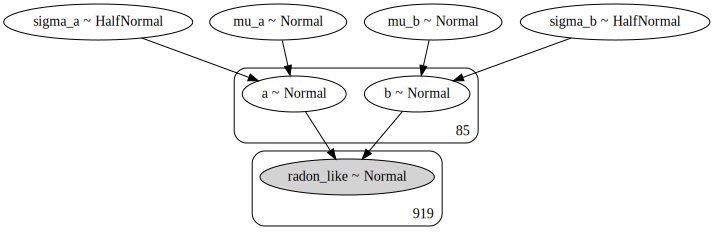

In [47]:
model_to_graphviz(hierarchical_model)

#### Inference 

In [48]:
with hierarchical_model:
    hierarchical_trace = pm.sample(2000, tune=2000, target_accept=.9, chains=4, cores=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [b, a, sigma_b, mu_b, sigma_a, mu_a]
Sampling chain 3, 148 divergences: 100%|██████████| 4000/4000 [00:24<00:00, 161.61it/s]
There were 767 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.516609948177931, but should be close to 0.9. Try to increase the number of tuning steps.
There were 992 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5974010089132719, but should be close to 0.9. Try to increase the number of tuning steps.
There were 1087 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6680291486531449, but should be close to 0.9. Try to increase the number of tuning steps.
There were 1235 divergences after tuning. 

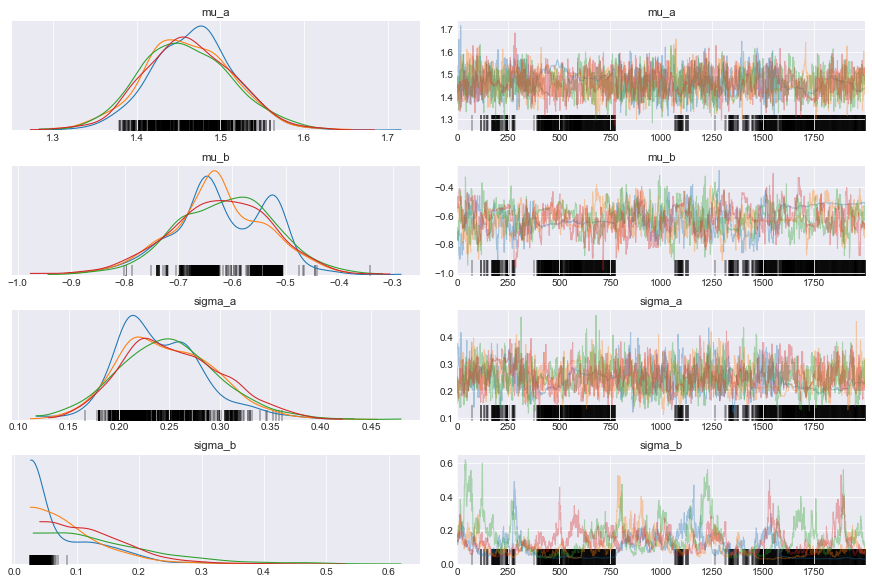

In [49]:
pm.traceplot(hierarchical_trace, var_names=['mu_a', 'mu_b',
                                            'sigma_a', 'sigma_b']);

In [50]:
results = pm.summary(hierarchical_trace) 
results[:10] 

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mu_a,1.462,0.052,1.374,1.565,0.002,0.002,535.0,534.0,535.0,2376.0,1.01
mu_b,-0.621,0.091,-0.798,-0.457,0.006,0.005,205.0,205.0,198.0,802.0,1.02
a[0],1.329,0.233,0.863,1.747,0.018,0.013,173.0,173.0,190.0,199.0,1.02
a[1],1.076,0.126,0.845,1.298,0.012,0.009,112.0,98.0,107.0,795.0,1.03
a[2],1.470,0.231,1.027,1.901,0.011,0.008,408.0,408.0,405.0,683.0,1.01
a[3],1.490,0.203,1.097,1.875,0.006,0.004,1056.0,1056.0,899.0,1632.0,1.01
a[4],1.452,0.224,1.044,1.892,0.013,0.009,318.0,291.0,334.0,250.0,1.02
a[5],1.464,0.247,1.069,1.995,0.017,0.013,220.0,196.0,244.0,147.0,1.02
a[6],1.727,0.192,1.381,2.096,0.008,0.006,569.0,556.0,565.0,556.0,1.01
a[7],1.575,0.225,1.142,1.991,0.008,0.006,815.0,815.0,793.0,1329.0,1.01


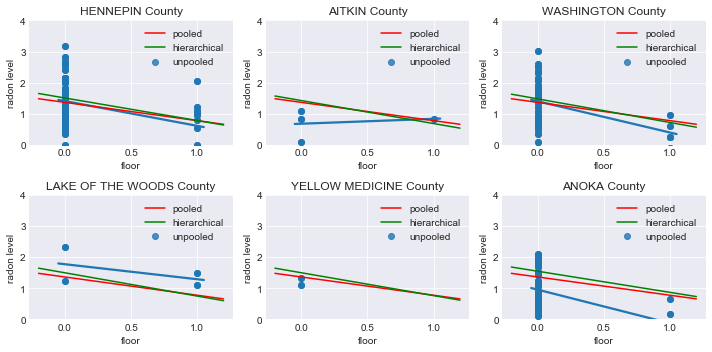

In [51]:
# plot just a subset of the countries
counties = ['HENNEPIN','AITKIN','WASHINGTON', 'LAKE OF THE WOODS', 'YELLOW MEDICINE', 'ANOKA']

plt.figure(figsize=(10,5))
rows = 2
gs = gridspec.GridSpec(rows, len(counties)//rows)
  
for i, county in enumerate(counties):
    county_data = data.loc[data['county']==county]
    subplt = plt.subplot(gs[i])
    
    # pooled line (single values coeff for all)
    xx = np.linspace(-0.2, 1.2)    
    radon_est = pooled_trace['a'].mean() + pooled_trace['b'].mean()*xx
    
    radon_est_hier = np.mean(hierarchical_trace['a'][i]) + \
                      np.mean(hierarchical_trace['b'][i])*xx 

    # un-pooled (single subject)
    sns.regplot(x='floor', y='log_radon', ci=None, label='unpooled',
                data=county_data).set_title('County '+str(county))
    
    # hierarchical line
    subplt.set_ylim(0.,4.)
    subplt.scatter(county_data['floor'], county_data['log_radon'])
    subplt.plot(xx, radon_est, c='r', label='pooled');
    
    # plot the hierarchical, varying coefficient model
    subplt.plot(xx, radon_est_hier, c='g', label='hierarchical');
    
    subplt.set_xlabel('floor', fontsize=10)
    subplt.set_ylabel('radon level', fontsize=10)
    subplt.set_title(str(county) + ' County')
    subplt.legend()
    plt.tight_layout()

This tutorial has borrowed from PyMC3 docs: https://docs.pymc.io/notebooks/GLM-hierarchical.html

<a id=LR></a>

### What about Logistic Regression?

If the problem above was a classification that required a Logistic Regression, we would use the logistic function ( where $\beta_0$ is the intercept, and $\beta_i$ (i=1, 2, 3) determines the shape of the logistic function).

\begin{equation}
Pr(Y=1|X_1,X_2,X3) = {\frac{1}{1 + exp^{-(\beta_0 + \beta_1X_1 + \beta_2X_2 + \beta_3X_3)}}}
\end{equation}

Since both $\beta_0$ and the $\beta_i$s can be any possitive or negative number, we can model them as gaussian random variables.

\begin{eqnarray}
\beta_0 \sim  \mathcal{N}(\mu,\,\sigma^2) \\
\beta_i \sim  \mathcal{N}(\mu_i,\,\sigma_i^2)
\end{eqnarray} 

In PyMC3 we can model those as:
```
pm.Normal('beta_0', mu=0, sigma=100)
```
(where $\mu$ and $\sigma^2$ can have some initial values that we assign them, e.g. 0 and 100)

The dererministic variable would be:
```
p-logit = beta0 + beta_1 * X_1 + beta_2 * X_2 + beta_3 * X_3
```
To connect this variable (p_logit) with our observed data, we would use a Bernoulli as our likelihood.
```
our_likelihood = pm.Bernoulli('our_likelihood', logit_p=p-logit, observed=our_data)
```

Notice that the main difference with Linear Regression is the use of a Bernoulli distribution instead of a Gaussian distribution, and the use of the logistic function instead of the identity function.

Note: we could explicitly create this variable using pm.Deterministic.
```
    mu = pm.Deterministic('mu', beta0 + beta_1*X_1 + beta_2*X_2 + beta_3*X_3)
```

Text(0, 0.5, 'y=logistic(x)')

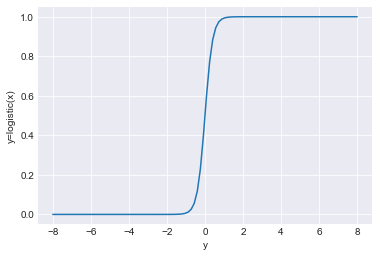

In [52]:
# A reminder of what the logistic function looks like. 
# Play with parameters a and b to see the shape of the curve change
b = 5.
x = np.linspace(-8, 8, 100)
plt.plot(x, 1 / (1 + np.exp(-b*x)))
plt.xlabel('y')
plt.ylabel('y=logistic(x)')

**References**:

- *Salvatier J, Wiecki TV, Fonnesbeck C. 2016. Probabilistic programming in Python using PyMC3. PeerJ Computer Science 2:e55* [(https://doi.org/10.7717/peerj-cs.55)](https://doi.org/10.7717/peerj-cs.55)
- [Distributions in PyMC3](https://docs.pymc.io/api/distributions.html)
- [More Details on Distributions](https://docs.pymc.io/developer_guide.html)

Information about PyMC3 functions including descriptions of distributions, sampling methods, and other functions, is available via the `help` command.

#### Cool Reading

- How Bayesian Analysis and Lawrence D. Stone found the Wreckage of [Air France Flight AF 447](https://www.jstor.org/stable/pdf/43288452.pdf?refreqid=excelsior%3Ae972f3a7b38b5815e1570b93dad7d269).
- Search for the gold on the sunken [SS Central America](https://www.metsci.com/wp-content/uploads/2019/08/Search-for-the-SS-Central-America-Mathematical-Treasure-Hunting-Interfaces-22-1-Jan.-Feb.-1992.pdf).